# AIN433 Assignment 4

##### Name: Emre Çoban
##### ID: 2200765028

In [1]:
# Import necessary libraries

import tensorflow as tf
import matplotlib.pyplot as plt
import os
import shutil
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.patches as patches
import numpy as np

In [2]:
# Check whether tensorflow uses GPU
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Preparing Data for PART 1 and PART 2

In [4]:
data_folder = "indoorCVPR_09"
images_folder = os.path.join(data_folder, "Images")
num_classes = 15

In [5]:
def split_and_create_datasets(images_folder, data_folder, num_classes, train_ratio=0.70, val_ratio=0.15, test_ratio=0.15):
    """
    Split and create datasets from an image folder.

    Args:
    - images_folder (str): Path to the folder containing the original image dataset.
    - data_folder (str): Root folder where new Train, Validation, and Test folders will be created.
    - num_classes (int): Number of classes to select for processing (top classes with the most images).
    - train_ratio (float): Ratio of images to allocate to the training set. Default is 0.70 (70%).
    - val_ratio (float): Ratio of images to allocate to the validation set. Default is 0.15 (15%).
    - test_ratio (float): Ratio of images to allocate to the test set. Default is 0.15 (15%).
    """
    # Set the seed for reproducibility
    random.seed(42)

    # Create folders for train, validation, and test datasets
    train_folder = os.path.join(data_folder, "Train")
    val_folder = os.path.join(data_folder, "Validation")
    test_folder = os.path.join(data_folder, "Test")

    # Ensure the existence of the dataset folders
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(val_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Dictionary to store the count of images in each class
    class_counts = {}

    # Count the number of images in each class
    for class_folder in os.listdir(images_folder):
        class_path = os.path.join(images_folder, class_folder)
        class_counts[class_folder] = len(os.listdir(class_path))

    # Select the top classes with the most images
    selected_classes = sorted(class_counts, key=class_counts.get, reverse=True)[:num_classes]

    # Loop through each class folder and split the images
    for class_folder in os.listdir(images_folder):
        class_path = os.path.join(images_folder, class_folder)

        # Process only the selected classes
        if class_folder in selected_classes:
            images = os.listdir(class_path)
            random.shuffle(images)

            num_images = len(images)
            num_train = int(train_ratio * num_images)
            num_val = int(val_ratio * num_images)

            # Split images into train, validation, and test sets
            train_images = images[:num_train]
            val_images = images[num_train:num_train + num_val]
            test_images = images[num_train + num_val:]

            # Copy images to the train folder
            for img in train_images:
                src_path = os.path.join(class_path, img)
                dst_path = os.path.join(train_folder, class_folder, img)
                os.makedirs(os.path.dirname(dst_path), exist_ok=True)
                shutil.copy(src_path, dst_path)

            # Copy images to the validation folder
            for img in val_images:
                src_path = os.path.join(class_path, img)
                dst_path = os.path.join(val_folder, class_folder, img)
                os.makedirs(os.path.dirname(dst_path), exist_ok=True)
                shutil.copy(src_path, dst_path)

            # Copy images to the test folder
            for img in test_images:
                src_path = os.path.join(class_path, img)
                dst_path = os.path.join(test_folder, class_folder, img)
                os.makedirs(os.path.dirname(dst_path), exist_ok=True)
                shutil.copy(src_path, dst_path)

# Example usage
split_and_create_datasets(images_folder, data_folder, num_classes)

Found 5387 images belonging to 15 classes.
Found 1148 images belonging to 15 classes.
Found 1171 images belonging to 15 classes.


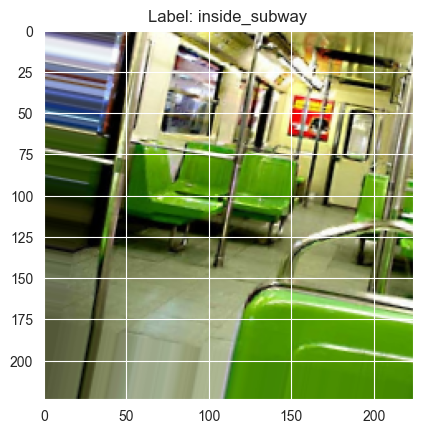

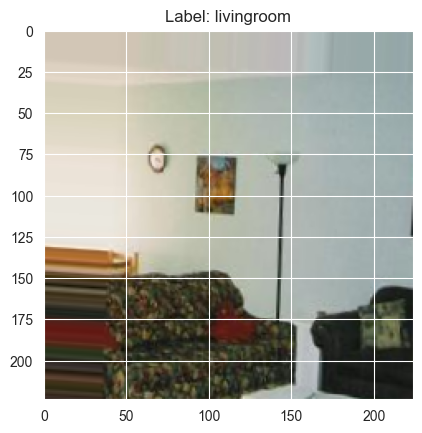

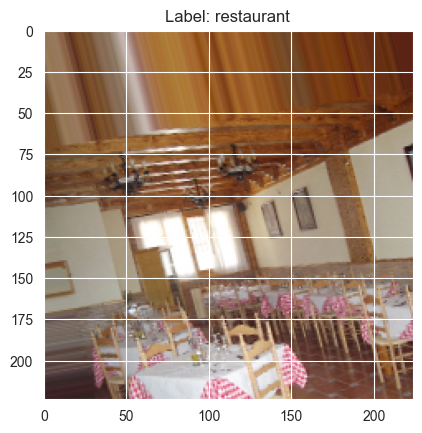

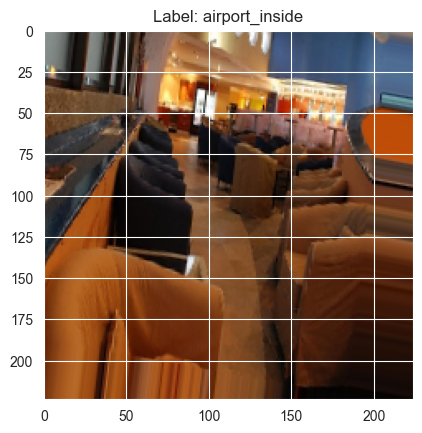

In [6]:
def create_datasets(batch_size, img_size=(224, 224)):
    """
    Create and return TensorFlow datasets for training, validation, and testing.

    Args:
    - batch_size (int): Batch size for training, validation, and testing datasets.
    - img_size (tuple): Target size for input images. Default is (224, 224).

    Returns:
    - train_dataset (tf.data.Dataset): Training dataset.
    - val_dataset (tf.data.Dataset): Validation dataset.
    - test_dataset (tf.data.Dataset): Testing dataset.
    """
    # Define directories for train, test, and validation datasets
    train_dir = os.path.join(data_folder, "Train")
    test_dir = os.path.join(data_folder, "Test")
    val_dir = os.path.join(data_folder, "Validation")

    # Define image data generators with augmentation for training and standard rescaling for testing
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        shear_range=0.2,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True
    )

    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255
    )

    # Create TensorFlow datasets for training, validation, and testing
    train_dataset = train_datagen.flow_from_directory(
        train_dir,
        class_mode="categorical",
        batch_size=batch_size,
        target_size=img_size,
        shuffle=True,
        seed=42
    )

    val_dataset = test_datagen.flow_from_directory(
        val_dir,
        class_mode="categorical",
        batch_size=batch_size,
        target_size=img_size,
        shuffle=True,
        seed=42
    )

    test_dataset = train_datagen.flow_from_directory(
        test_dir,
        class_mode="categorical",
        batch_size=batch_size,
        target_size=img_size,
        shuffle=True,
        seed=42
    )

    return train_dataset, val_dataset, test_dataset

# Example usage
train_dataset, val_dataset, test_dataset = create_datasets(16)

# Get class names from the training dataset
class_names = list(train_dataset.class_indices.keys())

# Number of images to display
num_images_to_display = 4

# Get the first batch from the train_dataset
batch = next(iter(train_dataset))

# Extract images and labels
images, labels = batch

# Visualize the first few images in the batch
for i in range(num_images_to_display):
    plt.figure()
    plt.imshow(images[i])
    class_idx = tf.argmax(labels[i]).numpy()
    class_name = class_names[class_idx]
    plt.title(f"Label: {class_name}")
    plt.show()


## Part 1

#### Creating Model

In [7]:
""" Model architecture 3 CONV Layers followed by max_pooling layers.
Batch norm after 2nd conv layer to regularize model.
3 L2 regularized dense layers dropout added between them if requested otherwise no dropout."""

def create_model(use_dropout=False, dropout_prob=0.5):
    """
    Create a convolutional neural network model with a specific architecture.

    Args:
    - use_dropout (bool): Flag to indicate whether to include dropout layers. Default is False.
    - dropout_prob (float): Dropout probability if use_dropout is True. Default is 0.5.

    Returns:
    - model (tf.keras.models.Sequential): Compiled CNN model.
    """
    model = tf.keras.models.Sequential([
        # CONV1
        tf.keras.layers.Conv2D(8, (5, 5), activation='relu', input_shape=(224, 224, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # CONV2
        tf.keras.layers.Conv2D(16, (5, 5), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        # Batch Norm
        tf.keras.layers.BatchNormalization(),

        # CONV3
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Flatten(),

        # FC with Regularization
        tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        # Add dropout if wanted otherwise just linear act. (does nothing)
        tf.keras.layers.Dropout(dropout_prob) if use_dropout else tf.keras.layers.Activation('linear'),

        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        # Add dropout if wanted otherwise just linear act. (does nothing)
        tf.keras.layers.Dropout(dropout_prob) if use_dropout else tf.keras.layers.Activation('linear'),

        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    return model

####  Why Put Dropout Between Dense Layers?
In the original paper that proposed dropout layers, by Hinton (2012), dropout (with p=0.5) was used on each of the fully connected (dense) layers before the output; it was not used on the convolutional layers. This became the most commonly used configuration.

### Batch Size and Learning Rate Experiments

In [78]:
# Create empty dictionaries to store histories
histories = {}

# Define different learning rates and batch sizes
learning_rates = [2e-3, 2e-5 , 2e-6]
batch_sizes = [16, 32]

# Iterate over different learning rates and batch sizes
for lr in learning_rates:
    for bs in batch_sizes:

        # Print information about the current training configuration
        print(f"\nTraining model with learning rate {lr}, batch size {bs}\n")

        # Create datasets for training, validation, and testing
        train_dataset, val_dataset, test_dataset = create_datasets(bs)

        # Create a model from scratch
        model = create_model(use_dropout=False)  # Train 6 experiments (3 lr * 2 batch_size)

        # Early Stopping with patience 10
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

        # Specify optimizer, loss, and learning rate
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        # Train the model and save the training history
        history = model.fit(train_dataset, epochs=100, batch_size=bs, validation_data=val_dataset, callbacks=[early_stopping], verbose=1)

        # Save the training history in the dictionary using the tuple (lr, bs) as the key
        histories[(lr, bs)] = history.history


Training model with learning rate 0.002, batch size 16

Found 5387 images belonging to 15 classes.
Found 1148 images belonging to 15 classes.
Found 1171 images belonging to 15 classes.
Epoch 1/100
337/337 [==============================] - 48s 140ms/step - loss: 5.3668 - accuracy: 0.0993 - val_loss: 2.9767 - val_accuracy: 0.1150
Epoch 2/100
337/337 [==============================] - 45s 133ms/step - loss: 2.8936 - accuracy: 0.1168 - val_loss: 2.7918 - val_accuracy: 0.1228
Epoch 3/100
337/337 [==============================] - 44s 131ms/step - loss: 2.7500 - accuracy: 0.1255 - val_loss: 2.7301 - val_accuracy: 0.1246
Epoch 4/100
337/337 [==============================] - 44s 132ms/step - loss: 2.6945 - accuracy: 0.1348 - val_loss: 2.7315 - val_accuracy: 0.1185
Epoch 5/100
337/337 [==============================] - 45s 132ms/step - loss: 2.6693 - accuracy: 0.1455 - val_loss: 2.7478 - val_accuracy: 0.1568
Epoch 6/100
337/337 [==============================] - 47s 141ms/step - loss: 2.6302

### Metrics For Learning Rate and Batch Size Experiments

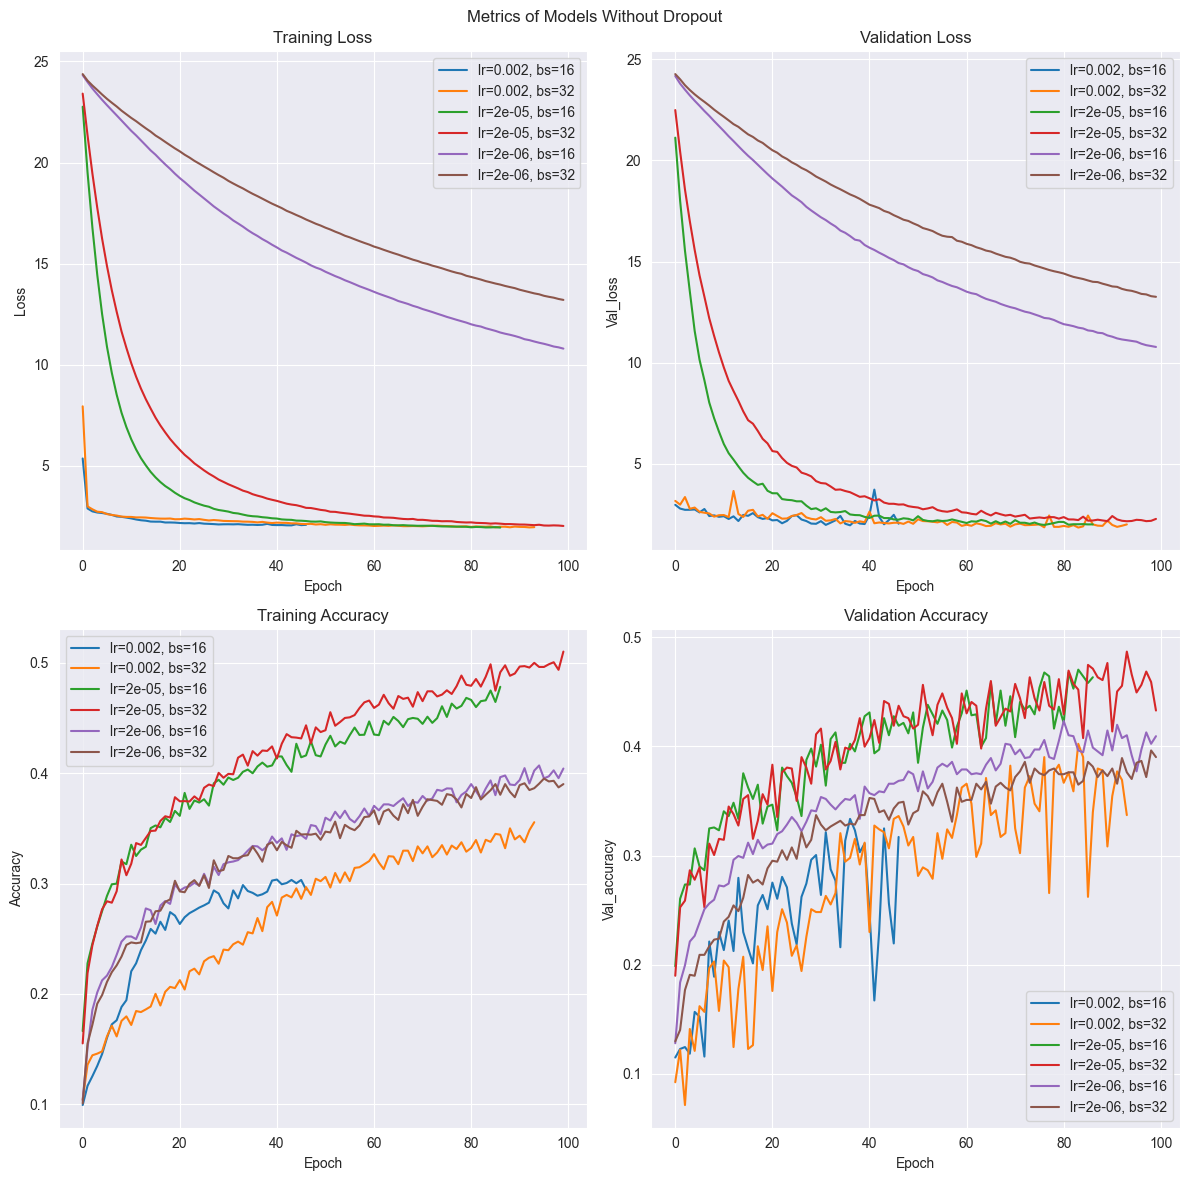

In [79]:
def plot_metrics(histories, title_suffix):
    plt.figure(figsize=(12, 12))
    plt.suptitle(f"Metrics of Models {title_suffix}")

    metrics = ['loss', 'val_loss', 'accuracy', 'val_accuracy']
    titles = ['Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy']

    for i, metric in enumerate(metrics, start=1):
        plt.subplot(2, 2, i)
        for (lr, bs), history in histories.items():
            plt.plot(history[metric], label=f'lr={lr}, bs={bs}')
        plt.title(titles[i - 1])
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()

    plt.tight_layout()
    plt.show()


plot_metrics(histories, title_suffix='Without Dropout')

When learning rate gets bigger looks like there is oscillation problem not finding global minima, but when we make learning rate smaller it can find global minima much easier.
In the graphs above its seen that batch_size=32 is outperforming batch_size=16 thus I will pick that , for learning rate part it looks like 2e-5 would work fine,  I'ts obvious that 2e-5 converges much more cleaner than 2e-6 and 2e-3. Especially 2e-3 learning rate has oscillation problems and from val loss graphs we can see that bet loss convergence line belongs to the model with 2e-5 and  batch_size=32 so I will move on with that model.

### Integrate Dropout

In [81]:
best_batch_size = 32
best_lr = 2e-5
train_dataset, val_dataset, test_dataset = create_datasets(best_batch_size)

histories = {}

for dropout_prob in [0.2, 0.3, 0.4, 0.5]:
    print(f"\nTraining model with dropout_prob = {dropout_prob}\n")
    model = create_model(use_dropout=True, dropout_prob=dropout_prob)

    # Specify optimizer, loss amd learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Define EarlyStopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model and save the history
    history = model.fit(train_dataset, epochs=100, batch_size=best_batch_size,
                  validation_data=val_dataset,
                  callbacks=[early_stopping],
                  verbose=1)

    histories[(dropout_prob)] = history.history

Found 5387 images belonging to 15 classes.
Found 1148 images belonging to 15 classes.
Found 1171 images belonging to 15 classes.

Training model with dropout_prob = 0.2

Epoch 1/100
169/169 [==============================] - 43s 252ms/step - loss: 23.4998 - accuracy: 0.1554 - val_loss: 22.6369 - val_accuracy: 0.2152
Epoch 2/100
169/169 [==============================] - 42s 248ms/step - loss: 21.5712 - accuracy: 0.1936 - val_loss: 20.7378 - val_accuracy: 0.2274
Epoch 3/100
169/169 [==============================] - 42s 247ms/step - loss: 19.7936 - accuracy: 0.2079 - val_loss: 18.9333 - val_accuracy: 0.2430
Epoch 4/100
169/169 [==============================] - 42s 249ms/step - loss: 18.1718 - accuracy: 0.2250 - val_loss: 17.3030 - val_accuracy: 0.2657
Epoch 5/100
169/169 [==============================] - 42s 245ms/step - loss: 16.6799 - accuracy: 0.2293 - val_loss: 15.9582 - val_accuracy: 0.2570
Epoch 6/100
169/169 [==============================] - 42s 247ms/step - loss: 15.3338 - ac

#### Metrics of Dropout  Experiments

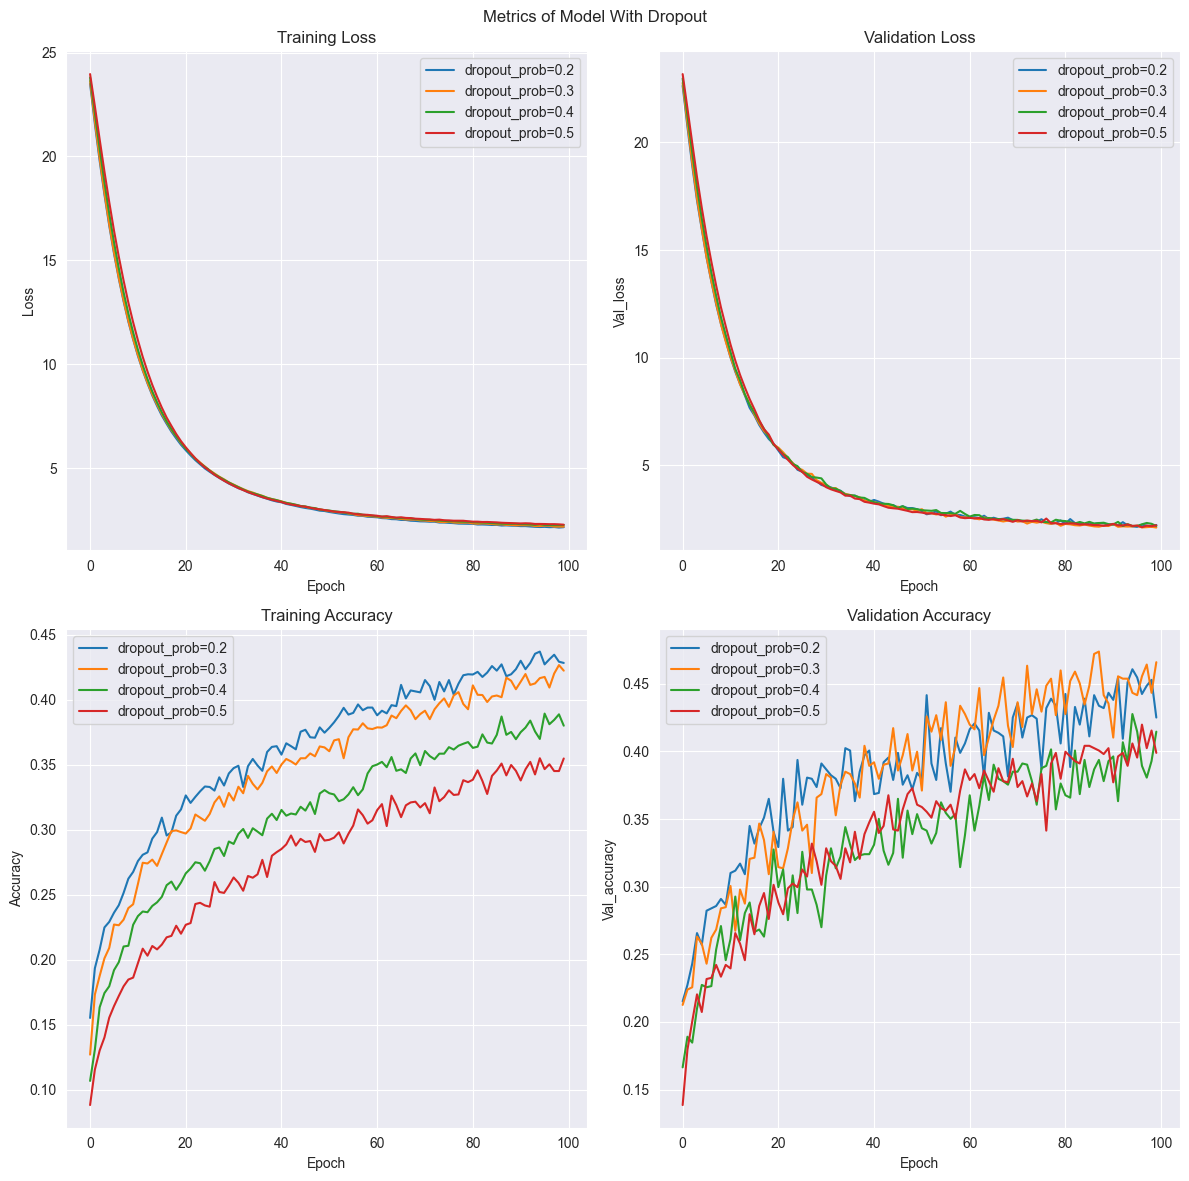

In [82]:
def plot_metrics_dropout(histories, title_suffix):
    plt.figure(figsize=(12, 12))
    plt.suptitle(f"Metrics of Model {title_suffix}")

    metrics = ['loss', 'val_loss', 'accuracy', 'val_accuracy']
    titles = ['Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy']

    for i, metric in enumerate(metrics, start=1):
        plt.subplot(2, 2, i)
        for dropout_prob, history in histories.items():
            plt.plot(history[metric], label=f'dropout_prob={dropout_prob}')
        plt.title(titles[i - 1])
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()

    plt.tight_layout()
    plt.show()


plot_metrics_dropout(histories, title_suffix='With Dropout')

As we can see from the graphs, dropout adds regularization to the model and prevents oscillations. This makes our model more generalized and performs better in unseen data. Larger dropout probablities like 0.4 and 0.5 leads to problem that model learns too slow thats why I will not use that probablities but 0.2 and 0.3 both looks fine I will go on with dropout probablity 0.3 since it has a bigger validation accuracy and lower validation loss which I value most.

### Train Best Model

Now, with a best_batch_size of 32 and an optimal learning rate (best_lr) of 2e-5, and dropout with probablity 0.3

In [83]:
best_model = create_model(use_dropout=True,dropout_prob=0.3)

# Specify optimizer, loss amd learning rate
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Early Stopping with patience 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=10,
                                                          restore_best_weights=True)

# Train the model and save the history
history = best_model.fit(train_dataset, epochs=100, batch_size=best_batch_size,
              validation_data=val_dataset,
                callbacks=[early_stopping],
              verbose=1)

Epoch 1/100
169/169 [==============================] - 45s 259ms/step - loss: 23.6509 - accuracy: 0.1184 - val_loss: 22.7186 - val_accuracy: 0.1211
Epoch 2/100
169/169 [==============================] - 43s 253ms/step - loss: 21.7079 - accuracy: 0.1327 - val_loss: 20.7278 - val_accuracy: 0.1864
Epoch 3/100
169/169 [==============================] - 43s 253ms/step - loss: 19.7933 - accuracy: 0.1639 - val_loss: 18.8373 - val_accuracy: 0.2082
Epoch 4/100
169/169 [==============================] - 43s 252ms/step - loss: 18.0249 - accuracy: 0.1804 - val_loss: 17.1015 - val_accuracy: 0.2108
Epoch 5/100
169/169 [==============================] - 42s 250ms/step - loss: 16.4276 - accuracy: 0.1970 - val_loss: 15.6246 - val_accuracy: 0.2395
Epoch 6/100
169/169 [==============================] - 43s 253ms/step - loss: 15.0117 - accuracy: 0.2014 - val_loss: 14.2322 - val_accuracy: 0.2526
Epoch 7/100
169/169 [==============================] - 43s 251ms/step - loss: 13.7500 - accuracy: 0.2202 - val_l

### Confusion Matrix and Metrics For The Best Model

37/37 [==============================] - 13s 363ms/step - loss: 2.1938 - accuracy: 0.4184
Test Accuracy : 0.41844576597213745
37/37 [==============================] - 10s 259ms/step


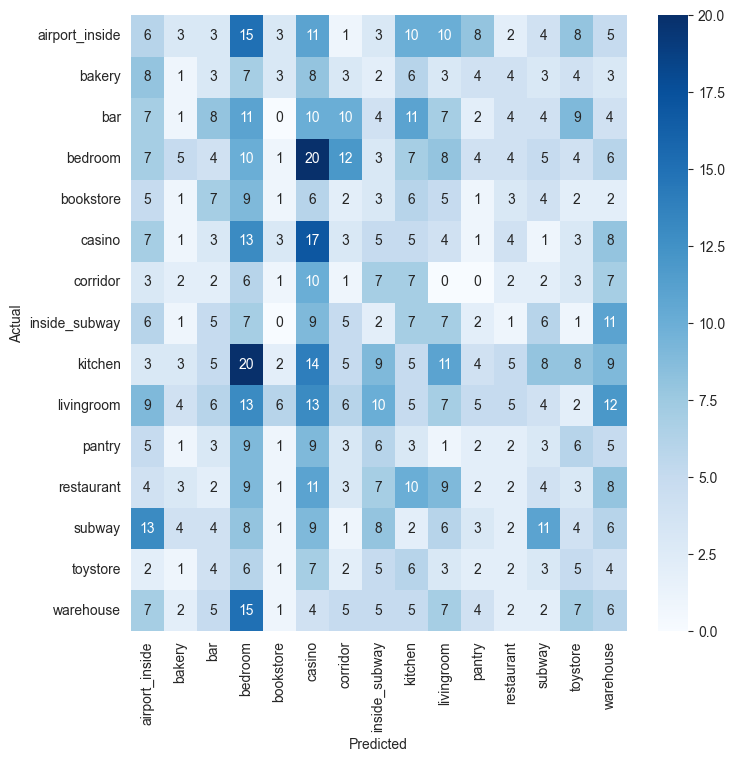

In [84]:
# Plot confusion matrix for the fine-tuned model
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

test_loss, test_acc = best_model.evaluate(test_dataset)
print("Test Accuracy :", test_acc)

# Get predictions for the test set
y_pred = best_model.predict(test_dataset).argmax(axis=1)
y_true = test_dataset.labels

plot_confusion_matrix(y_true, y_pred)


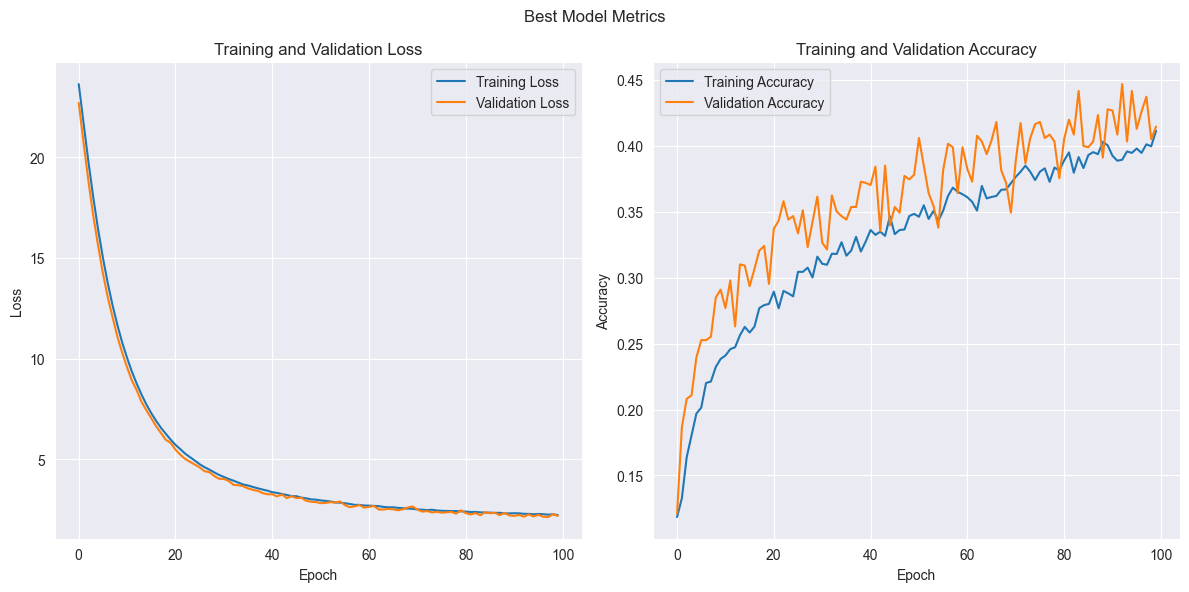

In [92]:
# Plot training and validation losses
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.suptitle('Best Model Metrics')


plt.tight_layout()
plt.show()

## Part 2

In [27]:
# Load data
train_dataset, val_dataset, test_dataset = create_datasets(best_batch_size)

Found 5387 images belonging to 15 classes.
Found 1148 images belonging to 15 classes.
Found 1171 images belonging to 15 classes.


In [32]:
# Load VGG-16 pre-trained on ImageNet (include_top=False to exclude FC layers)
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Lets see model's architecture
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Train only FC Layers

Original VGG16 Has 3 FC layers which gives these outputs 4048,4048,1000 this is pretty normal for the case when dataset is like imagenet which has 1000 class but in our case since we have 15 class I decided to implement custom FC Layers to fit our case. For that purpose I picked, 2048,256,15 FC layers which is more convenient for our data

In [34]:
# Load VGG-16 pre-trained on ImageNet (include_top=False to exclude FC layers)
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers  in the pre-trained VGG-16 model
for layer in base_model.layers:
    layer.trainable = False

# Add FC Layers which will be trainable

model_1 = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2048, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), name="fc1"),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), name="fc2"),
    tf.keras.layers.Dense(num_classes, activation='softmax', name="prediction")
])

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 fc1 (Dense)                 (None, 2048)              51382272  
                                                                 
 fc2 (Dense)                 (None, 256)               524544    
                                                                 
 prediction (Dense)          (None, 15)                3855      
                                                                 
Total params: 66,625,359
Trainable params: 51,910,671
Non-trainable params: 14,714,688
_________________________________________________________________


In [35]:
# Compile the model with specified optimizer, loss function, and metrics
model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Define EarlyStopping callback to stop training when validation loss plateaus
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history_fc = model_1.fit(train_dataset, epochs=100, validation_data=val_dataset, callbacks=[early_stopping])

Epoch 1/100
169/169 [==============================] - 51s 294ms/step - loss: 38.2266 - accuracy: 0.3644 - val_loss: 32.3382 - val_accuracy: 0.5427
Epoch 2/100
169/169 [==============================] - 44s 257ms/step - loss: 28.4881 - accuracy: 0.5365 - val_loss: 24.7939 - val_accuracy: 0.6333
Epoch 3/100
169/169 [==============================] - 43s 255ms/step - loss: 22.3737 - accuracy: 0.5846 - val_loss: 19.9180 - val_accuracy: 0.6394
Epoch 4/100
169/169 [==============================] - 44s 259ms/step - loss: 18.2951 - accuracy: 0.6152 - val_loss: 16.5849 - val_accuracy: 0.6725
Epoch 5/100
169/169 [==============================] - 44s 258ms/step - loss: 15.4860 - accuracy: 0.6399 - val_loss: 14.2445 - val_accuracy: 0.6847
Epoch 6/100
169/169 [==============================] - 44s 258ms/step - loss: 13.4878 - accuracy: 0.6441 - val_loss: 12.4951 - val_accuracy: 0.7282
Epoch 7/100
169/169 [==============================] - 44s 257ms/step - loss: 11.9541 - accuracy: 0.6679 - val_l

### Train after Last 3 Conv Layers + FC Layers

In [38]:
# Load VGG-16 pre-trained on ImageNet (include_top=False to exclude FC layers)
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers except FC Layers in the pre-trained VGG-16 model
for layer in base_model.layers[:-4]:
    layer.trainable = False

model_2 = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2048, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), name="fc1"),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), name="fc2"),
    tf.keras.layers.Dense(num_classes, activation='softmax', name="prediction")
])

model_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 fc1 (Dense)                 (None, 2048)              51382272  
                                                                 
 fc2 (Dense)                 (None, 256)               524544    
                                                                 
 prediction (Dense)          (None, 15)                3855      
                                                                 
Total params: 66,625,359
Trainable params: 58,990,095
Non-trainable params: 7,635,264
_________________________________________________________________


In [39]:
# Compile the model with specified optimizer, loss function, and metrics
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Define EarlyStopping callback to stop training when validation loss plateaus
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history_conv = model_2.fit(train_dataset, epochs=100, validation_data=val_dataset, callbacks=[early_stopping])

Epoch 1/100
169/169 [==============================] - 46s 260ms/step - loss: 38.3412 - accuracy: 0.4134 - val_loss: 33.2953 - val_accuracy: 0.5732
Epoch 2/100
169/169 [==============================] - 43s 254ms/step - loss: 30.0244 - accuracy: 0.6104 - val_loss: 26.9545 - val_accuracy: 0.7030
Epoch 3/100
169/169 [==============================] - 43s 254ms/step - loss: 24.8334 - accuracy: 0.6703 - val_loss: 22.7340 - val_accuracy: 0.7230
Epoch 4/100
169/169 [==============================] - 43s 254ms/step - loss: 21.1582 - accuracy: 0.7145 - val_loss: 19.6568 - val_accuracy: 0.7256
Epoch 5/100
169/169 [==============================] - 43s 254ms/step - loss: 18.4043 - accuracy: 0.7553 - val_loss: 17.2500 - val_accuracy: 0.7692
Epoch 6/100
169/169 [==============================] - 43s 254ms/step - loss: 16.2375 - accuracy: 0.7797 - val_loss: 15.4221 - val_accuracy: 0.7753
Epoch 7/100
169/169 [==============================] - 43s 256ms/step - loss: 14.4765 - accuracy: 0.8060 - val_l

### Compare 2 Models Metrics

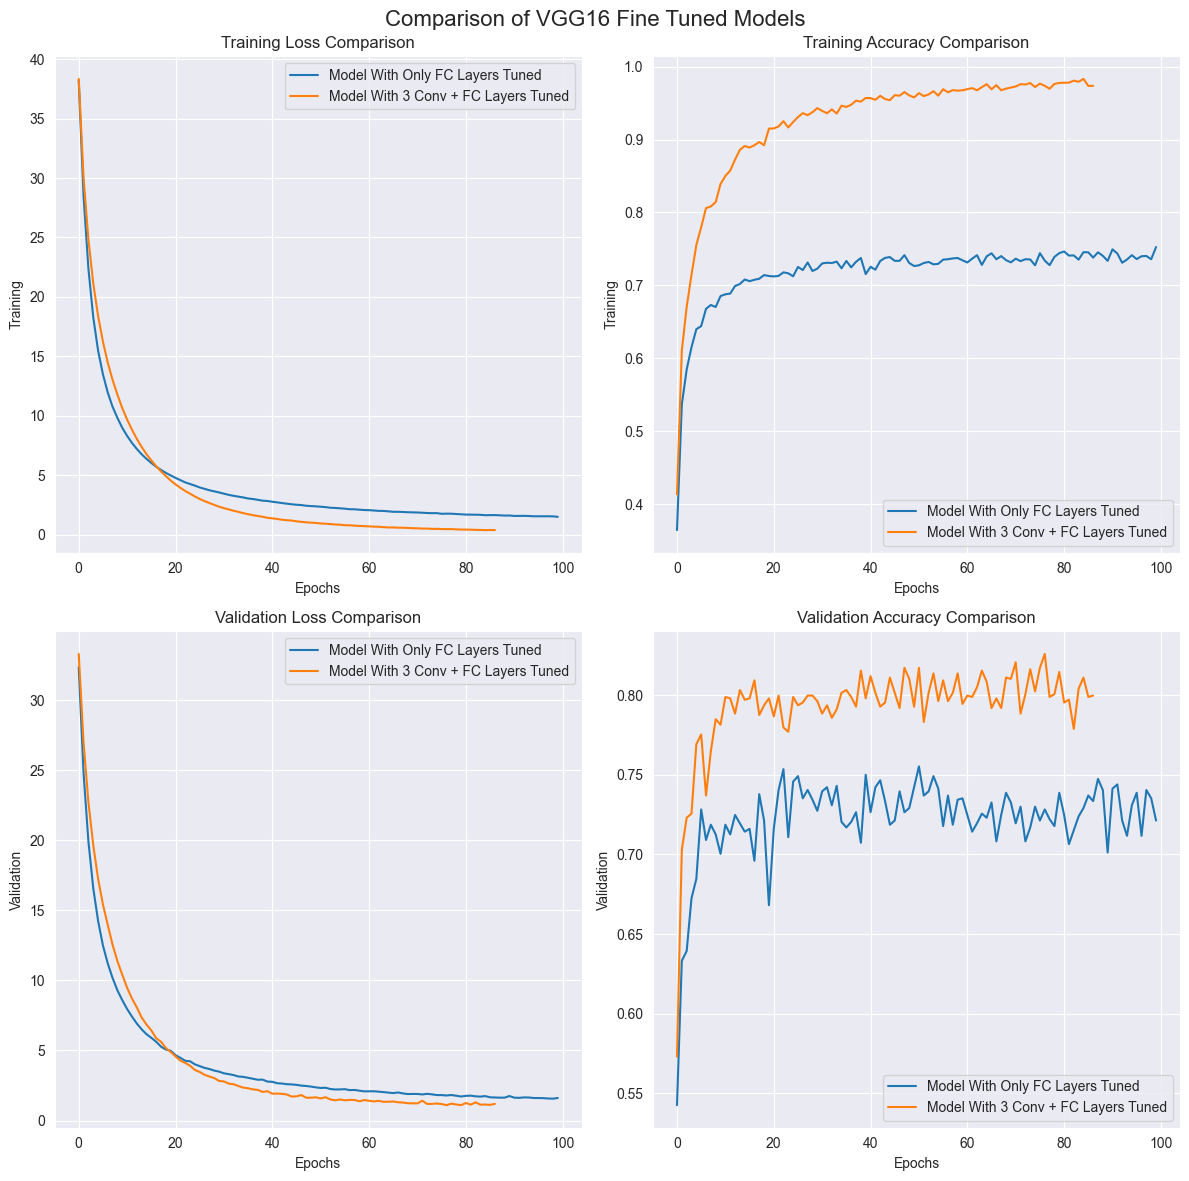

In [49]:

titles = ['Training Loss', 'Training Accuracy', 'Validation Loss', 'Validation Accuracy']
metrics = ['loss', 'accuracy', 'val_loss', 'val_accuracy']

plt.figure(figsize=(12, 12))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(history_fc.history[metrics[i]], label='Model With Only FC Layers Tuned')
    plt.plot(history_conv.history[metrics[i]], label='Model With 3 Conv + FC Layers Tuned')
    plt.title(f'{titles[i]} Comparison')
    plt.xlabel('Epochs')
    plt.ylabel(titles[i].split()[0])  # Use the first word of the title as the ylabel
    plt.legend()

plt.suptitle('Comparison of VGG16 Fine Tuned Models', fontsize=16)
plt.tight_layout()
plt.show()


Now I have picked Model with 3 Convolution + FC Layers tuned because It has a higher validation accuracy and lower validation loss

### Fine Tune the Selected Model

In [10]:
def get_vgg16_model():
    # Load VGG-16 pre-trained on ImageNet (include_top=False to exclude FC layers)
    vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze all layers except 3 CONV Layers in the pre-trained VGG-16 model
    for lay in vgg16.layers[:-4]:
        lay.trainable = False

    # Add FC Layers
    model2tune = tf.keras.models.Sequential([
        vgg16,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(2048, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), name="fc1"),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), name="fc2"),
        tf.keras.layers.Dense(num_classes, activation='softmax', name="prediction")
    ])

    return model2tune

For model from scratch in part 1 I tried learning rates  2e-3, 2e-5 and 2e-6 but for VGG16 Fine tuned model 2e-3 is too big learning rate and model doesn't learn at all so for this experiment I picked learning rates 2e-4, 2e-5 and 2e-6 to see which one performs better.

In [11]:
# Create empty dictionaries to store histories
histories = {}

# Define different learning rates and batch sizes
learning_rates = [2e-4, 2e-5, 2e-6]
batch_sizes = [16, 32]

# Iterate over different learning rates and batch sizes
for lr in learning_rates:
    for bs in batch_sizes:

        # Print information about the current training configuration
        print(f"\nTraining model with learning rate {lr}, batch size {bs}\n")

        # Create datasets for training, validation, and testing
        train_dataset, val_dataset, test_dataset = create_datasets(bs)


        model = get_vgg16_model()  # Train 6 experiments (3 lr * 2 batch_size)

        # Early Stopping with patience 10
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

        # Specify optimizer, loss, and learning rate
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        # Train the model and save the training history
        history = model.fit(train_dataset, epochs=100, batch_size=bs, validation_data=val_dataset, callbacks=[early_stopping], verbose=1)

        # Save the training history in the dictionary using the tuple (lr, bs) as the key
        histories[(lr, bs)] = history.history



Training model with learning rate 0.0002, batch size 16

Found 5387 images belonging to 15 classes.
Found 1148 images belonging to 15 classes.
Found 1171 images belonging to 15 classes.
Epoch 1/100
337/337 [==============================] - 60s 147ms/step - loss: 8.4501 - accuracy: 0.2851 - val_loss: 2.9243 - val_accuracy: 0.4347
Epoch 2/100
337/337 [==============================] - 43s 128ms/step - loss: 2.4210 - accuracy: 0.4912 - val_loss: 1.8331 - val_accuracy: 0.6045
Epoch 3/100
337/337 [==============================] - 43s 128ms/step - loss: 1.8014 - accuracy: 0.5803 - val_loss: 1.6566 - val_accuracy: 0.5906
Epoch 4/100
337/337 [==============================] - 43s 129ms/step - loss: 1.4604 - accuracy: 0.6356 - val_loss: 1.3166 - val_accuracy: 0.6847
Epoch 5/100
337/337 [==============================] - 43s 128ms/step - loss: 1.2521 - accuracy: 0.6794 - val_loss: 1.2244 - val_accuracy: 0.6786
Epoch 6/100
337/337 [==============================] - 43s 129ms/step - loss: 1.126

### Metrics Of The Fine Tuned Model

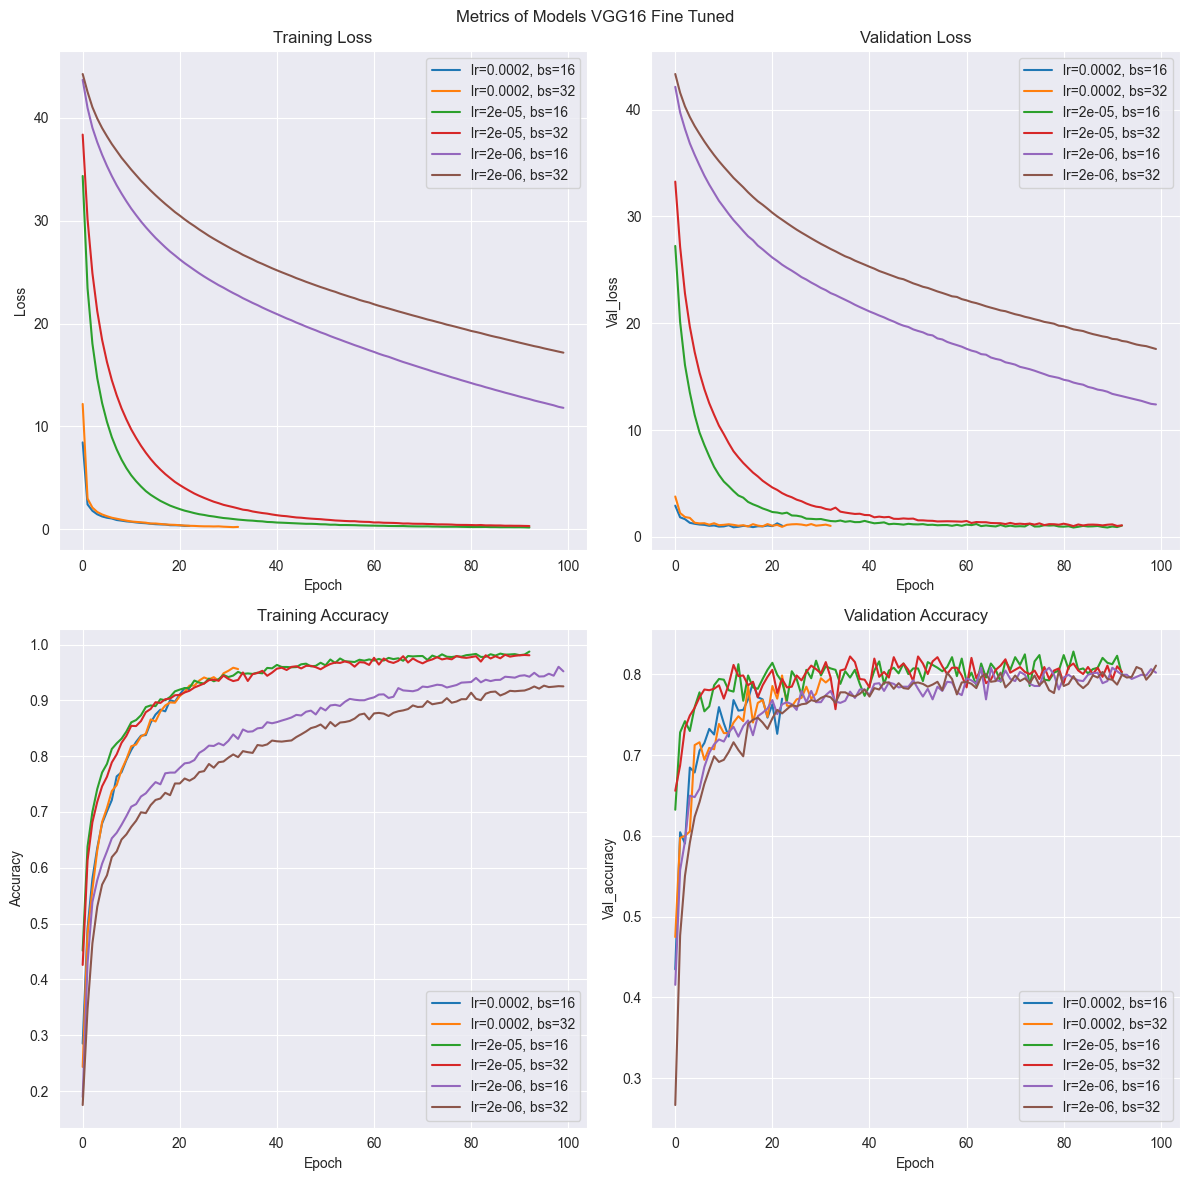

In [12]:
def plot_metrics(histories):
    plt.figure(figsize=(12, 12))
    plt.suptitle(f"Metrics of Models VGG16 Fine Tuned")

    metrics = ['loss', 'val_loss', 'accuracy', 'val_accuracy']
    titles = ['Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy']

    for i, metric in enumerate(metrics, start=1):
        plt.subplot(2, 2, i)
        for (lr, bs), history in histories.items():
            plt.plot(history[metric], label=f'lr={lr}, bs={bs}')
        plt.title(titles[i - 1])
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()

    plt.tight_layout()
    plt.show()


plot_metrics(histories)

Now from the graphs we can easily see that lr=2e-4 oscillates too mcuh so we will skip that and lr=2e-6 learns too slowly so we will pick 2e-5. For batch size both of them looks good but batch_size=16 looks like have more validation accuracy and less validation loss so I will move on with that choice. Now lets train the final best model with specified parameters.

### Train Final Best VGG16 Fine Tuned Model With Specified Parameters

In [13]:
best_batch_size=16
best_lr = 2e-5

train_dataset, val_dataset, test_dataset = create_datasets(best_batch_size)
best_model = get_vgg16_model()

# Specify optimizer, loss amd learning rate
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Early Stopping with patience 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=10,
                                                          restore_best_weights=True)

# Train the model and save the history
history = best_model.fit(train_dataset, epochs=100, batch_size=best_batch_size,
              validation_data=val_dataset,
                callbacks=[early_stopping],
              verbose=1)

Found 5387 images belonging to 15 classes.
Found 1148 images belonging to 15 classes.
Found 1171 images belonging to 15 classes.
Epoch 1/100
337/337 [==============================] - 44s 129ms/step - loss: 34.7501 - accuracy: 0.4388 - val_loss: 27.8280 - val_accuracy: 0.6289
Epoch 2/100
337/337 [==============================] - 43s 128ms/step - loss: 24.0631 - accuracy: 0.6278 - val_loss: 20.7048 - val_accuracy: 0.7334
Epoch 3/100
337/337 [==============================] - 44s 129ms/step - loss: 18.6295 - accuracy: 0.7080 - val_loss: 16.6968 - val_accuracy: 0.7448
Epoch 4/100
337/337 [==============================] - 43s 128ms/step - loss: 15.2251 - accuracy: 0.7362 - val_loss: 13.8656 - val_accuracy: 0.7587
Epoch 5/100
337/337 [==============================] - 44s 130ms/step - loss: 12.7400 - accuracy: 0.7650 - val_loss: 11.7807 - val_accuracy: 0.7631
Epoch 6/100
337/337 [==============================] - 44s 130ms/step - loss: 10.8152 - accuracy: 0.7899 - val_loss: 10.1439 - val_

### Confusion Matrix and Metrics of the Best Model from Part 2

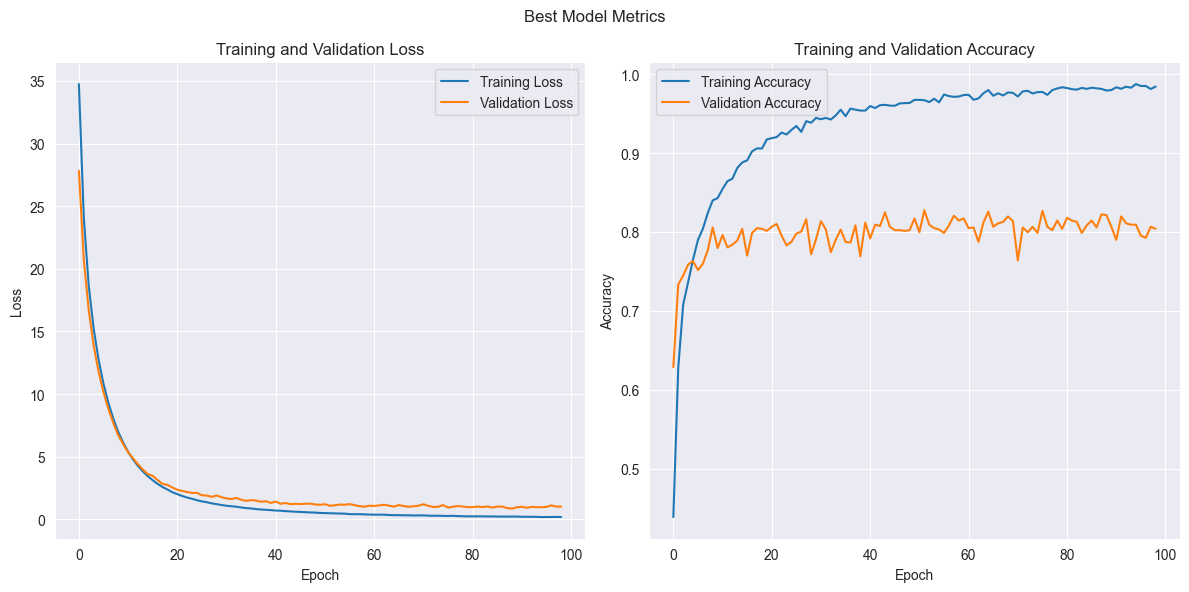

In [18]:
# Plot training and validation losses
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.suptitle('Best Model Metrics')


plt.tight_layout()
plt.show()

74/74 [==============================] - 9s 121ms/step - loss: 0.9061 - accuracy: 0.7985
Test Accuracy of Fine Tuned VGG16 Model: 0.7984628677368164
74/74 [==============================] - 9s 122ms/step
---------Confusion Matrix For Fine Tuned VGG16 Model-----------


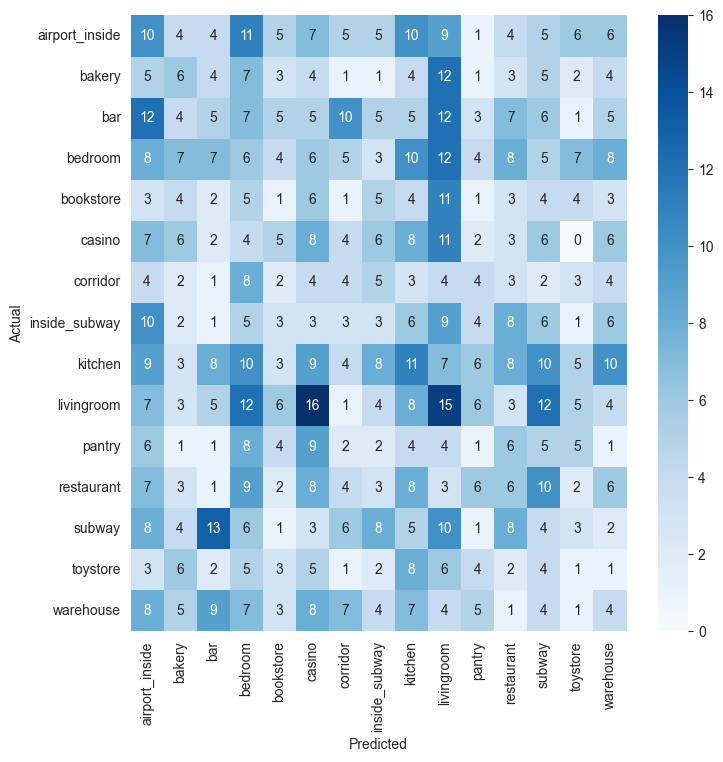

In [17]:
# Evaluate on test set
test_loss, test_acc= best_model.evaluate(test_dataset)
print("Test Accuracy of Fine Tuned VGG16 Model:", test_acc)

# Get predictions for the test set
y_pred = best_model.predict(test_dataset).argmax(axis=1)
y_true = test_dataset.labels

# Plot confusion matrix for FC layers
print("---------Confusion Matrix For Fine Tuned VGG16 Model-----------")
plot_confusion_matrix(y_true, y_pred)

### Comparison of Models from Part1 and Part2

As we can see from both the validation loss and the test loss VGG16 Fine-Tuned model outperforms our model from scratch as expected. Because VGG16 Model has more layers which makes that model capable of learning more complex patterns also this model was trained with a huge dataset called "ImageNet" thus it is acceptable that VGG16 outperforms our model from scratch. To improve our model from scratch we can add more conv layer more fc layers and make it more deep so it can understand more complex patterns too.

## Part 3

#### Prepare Data

In [3]:
DATA_DIR = "Raccoon.v2-raw.yolov4pytorch"

In [4]:
def load_data(data_dir, split):
    """
    Load images and bounding boxes from the specified split of the dataset.

    Args:
    - data_dir (str): Root directory of the dataset.
    - split (str): Split of the dataset ("train", "valid", or "test").

    Returns:
    - image_paths (list): List of file paths to the images.
    - bounding_boxes (list): List of bounding boxes for each image.
    """
    # Read annotations from the specified split
    with open(os.path.join(data_dir, split, "_annotations.txt")) as file:
        annotations = file.read().splitlines()

    # Lists to store image paths and corresponding bounding boxes
    image_paths = []
    bounding_boxes = []

    # Parse annotations to extract image paths and bounding boxes
    for line in annotations:
        parts = line.split()
        image_path = os.path.join(data_dir, split, parts[0])
        boxes = [list(map(float, box.split(','))) for box in parts[1:]]

        # Check if the image has only one bounding box
        if len(boxes) == 1:
            image_paths.append(image_path)
            bounding_boxes.append(boxes)

    return image_paths, bounding_boxes

# Load Training Images and Annotations
train_image_paths, train_bounding_boxes = load_data(DATA_DIR, "train")

# Load Validation Images and Annotations
val_image_paths, val_bounding_boxes = load_data(DATA_DIR, "valid")

# Load Test Images and Annotations
test_image_paths, test_bounding_boxes = load_data(DATA_DIR, "test")

In [5]:
def load_and_preprocess_image(image_paths, bounding_boxes):
    """
    Load and preprocess images along with adjusting bounding boxes.

    Args:
    - image_paths (list): List of file paths to the images.
    - bounding_boxes (list): List of bounding boxes for each image.

    Returns:
    - all_images (list): List of preprocessed image arrays.
    - adjusted_bounding_boxes (list): List of adjusted bounding boxes.
    - labels (list): List of labels associated with each bounding box.
    """
    all_images = []
    adjusted_bounding_boxes = []
    labels = []

    # Iterate over image paths and bounding boxes
    for img_path, boxes in zip(image_paths, bounding_boxes):
        # Load original image
        img = tf.keras.preprocessing.image.load_img(img_path)
        original_size = img.size

        # Load and resize image
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img)

        # Preprocess image (you can add more preprocessing steps as needed)
        img_array /= 255.0
        all_images.append(img_array)

        # Adjust bounding boxes based on the resizing
        target_size = (224, 224)
        scale_factor_x = target_size[0] / original_size[0]
        scale_factor_y = target_size[1] / original_size[1]

        adjusted_boxes = []

        for box in boxes:
            adjusted_box = [
                np.float32(round(box[0] * scale_factor_x)),  # xmin
                np.float32(round(box[1] * scale_factor_y)),  # ymin
                np.float32(round(box[2] * scale_factor_x)),  # xmax
                np.float32(round(box[3] * scale_factor_y))  # ymax
            ]

            labels.append([box[4]])
            adjusted_boxes.append(adjusted_box)

        adjusted_bounding_boxes.append(adjusted_boxes)

    return all_images, adjusted_bounding_boxes, labels


def create_dataset(batch_size=16):
    """
    Create TensorFlow datasets for training, validation, and testing.

    Args:
    - batch_size (int): Batch size for training, validation, and testing datasets.

    Returns:
    - train_dataset (tf.data.Dataset): Training dataset.
    - val_dataset (tf.data.Dataset): Validation dataset.
    - test_dataset (tf.data.Dataset): Testing dataset.
    """
    # Load and preprocess images for training, validation, and testing
    X_train, train_bboxes, train_labels = load_and_preprocess_image(train_image_paths, train_bounding_boxes)
    X_val, val_bboxes, val_labels = load_and_preprocess_image(val_image_paths, val_bounding_boxes)
    X_test, test_bboxes, test_labels = load_and_preprocess_image(test_image_paths, test_bounding_boxes)

    # Create TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, {'bbox_regression': train_bboxes, 'classification': train_labels}))
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, {'bbox_regression': val_bboxes, 'classification': val_labels}))
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, {'bbox_regression': test_bboxes, 'classification': test_labels}))

    # Batch the datasets
    train_dataset = train_dataset.batch(batch_size)
    val_dataset = val_dataset.batch(batch_size)
    test_dataset = test_dataset.batch(batch_size)

    return train_dataset, val_dataset, test_dataset

# To show examples
X_train, train_bboxes, train_labels = load_and_preprocess_image(train_image_paths, train_bounding_boxes)


Example Bounding Boxes Drawn over images:
Bounding Box(es) : [[51.0, 4.0, 164.0, 223.0]]


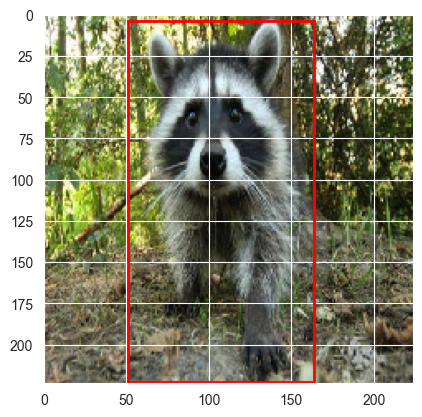

Bounding Box(es) : [[43.0, 19.0, 215.0, 191.0]]


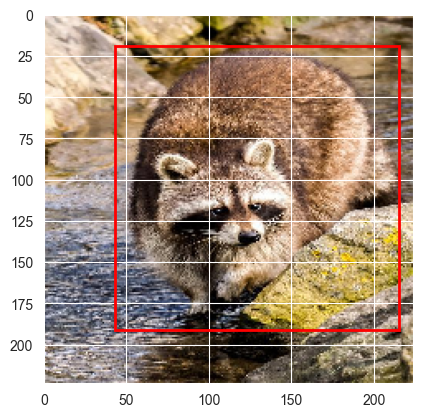

Bounding Box(es) : [[82.0, 12.0, 210.0, 223.0]]


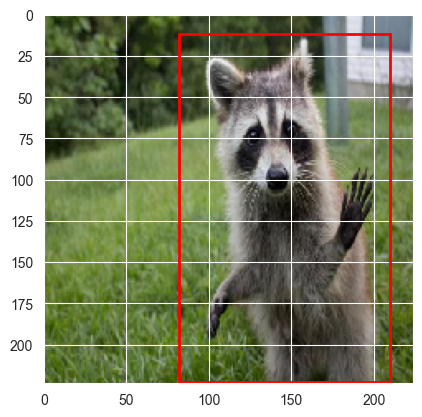

In [6]:
def plot_images_with_boxes(images, bounding_boxes, num_images_to_plot=3):
    # Select random indices
    random_indices = random.sample(range(len(images)), num_images_to_plot)

    # Iterate through randomly selected images
    for i in random_indices:
        image = images[i]
        boxes = bounding_boxes[i]
        print(f"Bounding Box(es) : {boxes}")

        # Create a figure and axis
        fig, ax = plt.subplots(1)
        ax.imshow(image)

        # Plot bounding boxes
        for box in boxes:
            x, y, x_max, y_max = box
            w = x_max - x
            h = y_max - y
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

        plt.show()

# Plot examples
print("Example Bounding Boxes Drawn over images:")
plot_images_with_boxes(X_train, train_bboxes)

#### Localization Model For Experiments

In [7]:
def localization_model(input_shape, num_classes):
    """
    Define a VGG16-based model with custom output layers for regression and classification.

    Args:
    - input_shape (tuple): Shape of the input images (height, width, channels).
    - num_classes (int): Number of classes for the classification output.

    Returns:
    - model (tf.keras.models.Model): VGG16-based model with custom output layers.
    """
    # Load VGG16 base model with pre-trained weights
    vgg16_base = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze convolutional layers
    for layer in vgg16_base.layers:
        layer.trainable = False

    # Flatten the output of VGG16
    x = tf.keras.layers.Flatten()(vgg16_base.output)

    # Fully connected layers for feature processing
    x = tf.keras.layers.Dense(2048, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(x)
    x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(x)

    # Bounding box regression branch
    bbox_regression = tf.keras.layers.Dense(4, name='bbox_regression')(x)

    # Classification branch
    classification = tf.keras.layers.Dense(num_classes, activation='sigmoid', name='classification')(x)

    # Create the final model
    model = tf.keras.models.Model(inputs=vgg16_base.input, outputs={'bbox_regression': bbox_regression, 'classification': classification})

    return model

 1/35 [..............................] - ETA: 1s - loss: 601.5879 - bbox_regression_loss: 578.1093 - classification_loss: 2.3488e-07

In [8]:
# Create empty dictionaries to store histories
histories = {}

# Define different learning rates and batch sizes
learning_rates = [2e-3, 2e-4, 2e-5]
batch_sizes = [4, 8]

# Iterate over different learning rates and batch sizes
for lr in learning_rates:
    for bs in batch_sizes:

        # Print information about the current training configuration
        print(f"\nTraining model with learning rate {lr}, batch size {bs}\n")

        # Create datasets for training, validation, and testing
        train_dataset, val_dataset, test_dataset = create_dataset(batch_size=bs)


        model = localization_model(input_shape=(224,224,3),num_classes=1)

        # Set up EarlyStopping callback
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_bbox_regression_loss', patience=20, restore_best_weights=True)

        # Specify optimizer, loss, and learning rate
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss={'bbox_regression': 'mean_squared_error', 'classification': 'binary_crossentropy'})

        # Train the model and save the training history
        history = model.fit(train_dataset, epochs=100, validation_data=val_dataset, batch_size=8, callbacks=[early_stopping])

        # Save the training history in the dictionary using the tuple (lr, bs) as the key
        histories[(lr, bs)] = history.history




Training model with learning rate 0.002, batch size 4

Epoch 1/100
35/35 [==============================] - 11s 70ms/step - loss: 2642.0095 - bbox_regression_loss: 2604.1174 - classification_loss: 0.7734 - val_loss: 931.7206 - val_bbox_regression_loss: 884.8805 - val_classification_loss: 4.7282e-17
Epoch 2/100
35/35 [==============================] - 1s 39ms/step - loss: 1546.9141 - bbox_regression_loss: 1499.5142 - classification_loss: 8.7329e-15 - val_loss: 1367.0569 - val_bbox_regression_loss: 1320.5951 - val_classification_loss: 3.9696e-17
Epoch 3/100
35/35 [==============================] - 1s 38ms/step - loss: 1338.4888 - bbox_regression_loss: 1292.4894 - classification_loss: 1.0976e-13 - val_loss: 749.3918 - val_bbox_regression_loss: 703.7509 - val_classification_loss: 1.9852e-18
Epoch 4/100
35/35 [==============================] - 1s 36ms/step - loss: 2014.5892 - bbox_regression_loss: 1969.2017 - classification_loss: 2.1843e-12 - val_loss: 1434.1102 - val_bbox_regression_loss:

### Metrics of Learning Rate and Batch Size Experiments

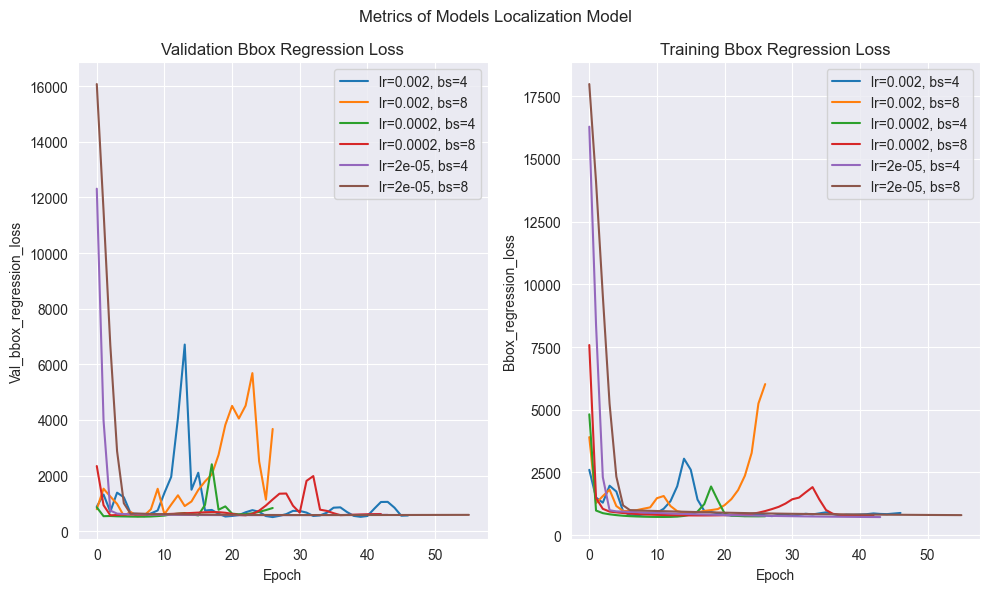

In [13]:
def plot_metrics(histories):
    plt.figure(figsize=(10,6))
    plt.suptitle(f"Metrics of Models Localization Model")

    metrics = ['val_bbox_regression_loss', 'bbox_regression_loss']
    titles = ['Validation Bbox Regression Loss', 'Training Bbox Regression Loss']

    for i, metric in enumerate(metrics, start=1):
        plt.subplot(1, 2, i)
        for (lr, bs), history in histories.items():
            plt.plot(history[metric], label=f'lr={lr}, bs={bs}')
        plt.title(titles[i - 1])
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()

    plt.tight_layout()
    plt.show()


plot_metrics(histories)

### Train The Best Model

In [14]:
best_batch_size = 8
best_lr = 2e-5

# Create datasets for training, validation, and testing
train_dataset, val_dataset, test_dataset = create_dataset(batch_size=best_batch_size)

model = localization_model(input_shape=(224,224,3),num_classes=1)  # Train 6 experiments (3 lr * 2 batch_size)

# Set up EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_bbox_regression_loss', patience=20, restore_best_weights=True)

# Specify optimizer, loss, and learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_lr),
      loss={'bbox_regression': 'mean_squared_error', 'classification': 'binary_crossentropy'})

model.fit(train_dataset, epochs=100, validation_data=val_dataset, batch_size=8, callbacks=[early_stopping])


Epoch 1/100
18/18 [==============================] - 2s 73ms/step - loss: 17503.9414 - bbox_regression_loss: 17461.6523 - classification_loss: 0.3853 - val_loss: 15262.7783 - val_bbox_regression_loss: 15220.7715 - val_classification_loss: 0.5753
Epoch 2/100
18/18 [==============================] - 1s 57ms/step - loss: 13075.3506 - bbox_regression_loss: 13033.1602 - classification_loss: 1.0649 - val_loss: 10240.2070 - val_bbox_regression_loss: 10197.2197 - val_classification_loss: 2.2202
Epoch 3/100
18/18 [==============================] - 1s 57ms/step - loss: 8206.4297 - bbox_regression_loss: 8162.5317 - classification_loss: 3.3927 - val_loss: 5369.3477 - val_bbox_regression_loss: 5323.6836 - val_classification_loss: 5.4659
Epoch 4/100
18/18 [==============================] - 1s 57ms/step - loss: 4086.4065 - bbox_regression_loss: 4039.6082 - classification_loss: 6.8338 - val_loss: 2058.3154 - val_bbox_regression_loss: 2009.6154 - val_classification_loss: 9.0100
Epoch 5/100
18/18 [=====

### Evaluating Model

In [15]:
model.evaluate(test_dataset)

2/2 [==============================] - 2s 1s/step - loss: 623.8022 - bbox_regression_loss: 591.7037 - classification_loss: 0.0058


[623.80224609375, 591.7037353515625, 0.005807589273899794]

### MIoU Calculation

In [16]:
def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - intersection

    return intersection / union

def calculate_miou(test_images, true_bboxes, model):
    true_bboxes_all = []
    predicted_bboxes_all = []

    for i in range(len(test_images)):
        image = tf.expand_dims(test_images[i], 0)
        prediction = model.predict(image)
        predicted_bbox = prediction['bbox_regression'][0]
        true_bboxes_for_image = true_bboxes[i]

        true_bboxes_all.extend(true_bboxes_for_image)
        predicted_bboxes_all.append(predicted_bbox)

    true_bboxes_all = np.array(true_bboxes_all)
    predicted_bboxes_all = np.array(predicted_bboxes_all)

    ious = [calculate_iou(true_bbox, pred_bbox) for true_bbox, pred_bbox in zip(true_bboxes_all, predicted_bboxes_all)]
    miou = np.mean(ious)

    return miou

# Test Data
X_test, test_bboxes, test_labels = load_and_preprocess_image(test_image_paths, test_bounding_boxes)

miou = calculate_miou(X_test, test_bboxes, model)
print(f"Mean Intersection over Union (mIoU): {miou:.4f}")

1/1 [==============================] - 0s 17ms/step
Mean Intersection over Union (mIoU): 0.6291


### Example Predictions

1/1 [==============================] - 0s 15ms/step


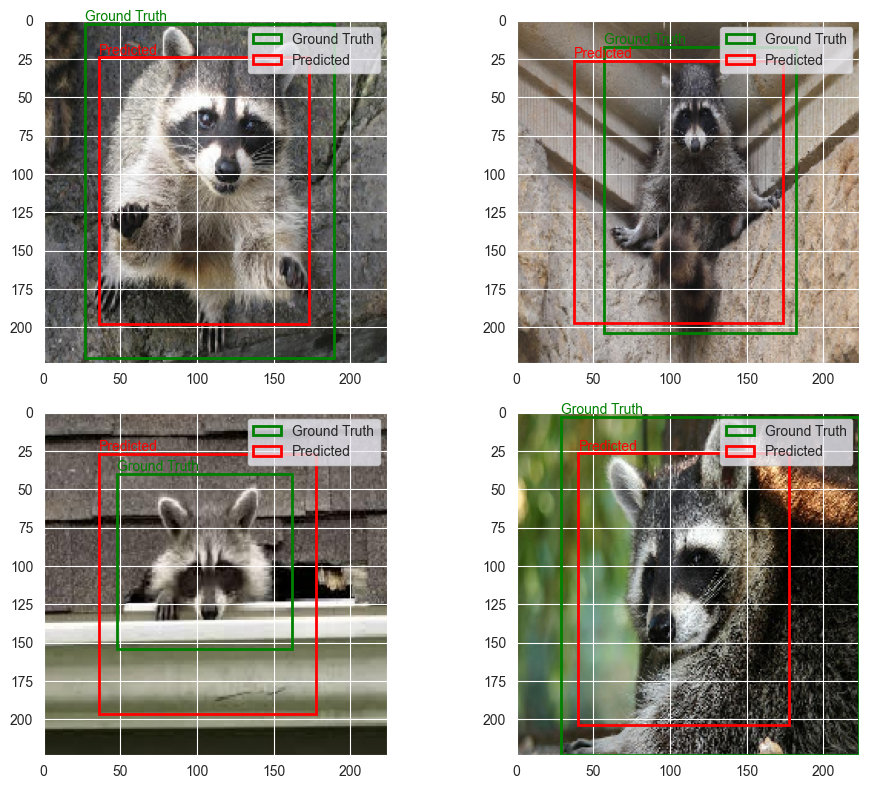

In [30]:
# Randomly plot 4 predictions
def plot_predictions(images, true_bboxes, model, num_predictions):
    random_indices = random.sample(range(len(images)), num_predictions)

    # Create a 2x2 subplot
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    for i, index in enumerate(random_indices):
        sample_image = tf.expand_dims(images[index], 0)
        prediction = model.predict(sample_image)

        true_bboxes_for_sample = true_bboxes[index]
        pred_bbox = prediction['bbox_regression'][0]

        ax = axs[i // 2, i % 2]
        ax.imshow(sample_image[0])

        for true_bbox in true_bboxes_for_sample:
            x, y, x_max, y_max = true_bbox
            w, h = x_max - x, y_max - y
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='g', facecolor='none', label='Ground Truth')
            ax.add_patch(rect)
            ax.text(x, y, 'Ground Truth', color='g', verticalalignment='bottom')

        x, y, x_max, y_max = pred_bbox
        w, h = x_max - x, y_max - y
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none', label='Predicted')
        ax.add_patch(rect)
        ax.text(x, y, 'Predicted', color='r', verticalalignment='bottom')

        ax.legend()

    plt.tight_layout()
    plt.show()

plot_predictions(X_test, test_bboxes, model, num_predictions=4)